# ДЗ 7. Тюнинг гиперпараметров, построение ансамблей алгоритмов

Чтобы было больше времени на выполнение курсовой работы, задание выполнить на наборе данных для соревнования: Тестовая выборка - это выборка для применения модели и загрузки на ЛБ.

## Библиотеки

In [1]:
import time
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from typing import Optional
from scipy.stats import gmean, rankdata

import warnings
warnings.simplefilter("ignore")

## Функции и скрипты

In [2]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=50, early_stopping_rounds=5000,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели xgboost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        model = xgb.XGBClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_train, y_train), (x_valid, y_valid)],
            early_stopping_rounds=5000,
            verbose=50)

        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)
        
    return estimators, encoders, oof_preds


def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_train, y_train), (x_valid, y_valid)],
            early_stopping_rounds=5000,
            cat_features=categorical)
        
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

## Загрузка данных

In [ ]:
train = pd.read_csv('./data/train.csv')
client_profile = pd.read_csv('./data/client_profile.csv')
bki = pd.read_csv('./data/bki.csv')
payments = pd.read_csv('./data/payments.csv')
applications_history = pd.read_csv('./data/applications_history.csv')

In [3]:
train['NAME_CONTRACT_TYPE'] = train['NAME_CONTRACT_TYPE'].map({'Credit Card': 0, 'Cash': 1})
train.head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,1
1,123597908,1,1
2,123526683,0,1


In [4]:
cp = client_profile.select_dtypes(include=np.number)
tr_cp = train.merge(cp, how='left', on='APPLICATION_NUMBER')
tr_cp.head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,0,1,1.0,157500.0,855000.0,25128.0,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0
1,123597908,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,0,1,0.0,135000.0,1006920.0,42660.0,0.026392,21557.0,3618.0,NaN,1.0,0.0,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0


In [5]:
bk = bki.groupby('APPLICATION_NUMBER').mean().reset_index()
tr_cp_bk = tr_cp.merge(bk, how='left', on='APPLICATION_NUMBER')
tr_cp_bk.head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BUREAU_ID,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123687442,0,1,1.0,157500.0,855000.0,25128.0,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,5.640206e+06,2562.000000,0.0,2197.000000,2162.000000,4714.425,0.0,56362.5,0.0000,0.0,0.0,2162.000000,NaN
1,123597908,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.951894e+06,869.555556,0.0,613.777778,590.800000,6925.014,0.0,142799.4,38934.5625,0.0,0.0,249.777778,NaN
2,123526683,0,1,0.0,135000.0,1006920.0,42660.0,0.026392,21557.0,3618.0,NaN,1.0,0.0,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,6.208402e+06,1648.222222,0.0,1105.125000,983.428571,0.000,0.0,730456.4,226206.0000,0.0,0.0,736.222222,13748.4


In [6]:
py = payments.groupby('APPLICATION_NUMBER').mean().reset_index()
tr_cp_bk_py = tr_cp_bk.merge(py, how='left', on='APPLICATION_NUMBER')
tr_cp_bk_py.head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BUREAU_ID,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,PREV_APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,123687442,0,1,1.0,157500.0,855000.0,25128.0,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,5.640206e+06,2562.000000,0.0,2197.000000,2162.000000,4714.425,0.0,56362.5,0.0000,0.0,0.0,2162.000000,NaN,49754880.5,1.0,5.75,2653.00,2659.0,6275.9250,3960.37125
1,123597908,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.951894e+06,869.555556,0.0,613.777778,590.800000,6925.014,0.0,142799.4,38934.5625,0.0,0.0,249.777778,NaN,49672074.0,1.0,9.00,450.00,457.0,11349.9000,11349.90000
2,123526683,0,1,0.0,135000.0,1006920.0,42660.0,0.026392,21557.0,3618.0,NaN,1.0,0.0,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,6.208402e+06,1648.222222,0.0,1105.125000,983.428571,0.000,0.0,730456.4,226206.0000,0.0,0.0,736.222222,13748.4,49376832.5,0.5,10.00,1917.25,1917.5,20169.4725,20169.47250


In [7]:
ap = applications_history.groupby('APPLICATION_NUMBER').mean().reset_index()
data = tr_cp_bk_py.merge(ap, how='left', on='APPLICATION_NUMBER')
data.head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT_x,AMOUNT_ANNUITY_x,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BUREAU_ID,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,PREV_APPLICATION_NUMBER_x,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,PREV_APPLICATION_NUMBER_y,AMOUNT_ANNUITY_y,AMT_APPLICATION,AMOUNT_CREDIT_y,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,123687442,0,1,1.0,157500.0,855000.0,25128.0,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,5.640206e+06,2562.000000,0.0,2197.000000,2162.000000,4714.425,0.0,56362.5,0.0000,0.0,0.0,2162.000000,NaN,49754880.5,1.0,5.75,2653.00,2659.0,6275.9250,3960.37125,4.977809e+07,7703.80500,68787.18,67592.10,4813.08,68787.18,1221.000000,86.666667,10.666667,365243.00,1168.0,1002.666667,122688.0,122675.333333,0.333333
1,123597908,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.951894e+06,869.555556,0.0,613.777778,590.800000,6925.014,0.0,142799.4,38934.5625,0.0,0.0,249.777778,NaN,49672074.0,1.0,9.00,450.00,457.0,11349.9000,11349.90000,4.947161e+07,27919.00125,331908.75,434949.75,0.00,331908.75,659.250000,38.750000,26.500000,365243.00,774.5,474.500000,474.5,465.500000,0.000000
2,123526683,0,1,0.0,135000.0,1006920.0,42660.0,0.026392,21557.0,3618.0,NaN,1.0,0.0,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,6.208402e+06,1648.222222,0.0,1105.125000,983.428571,0.000,0.0,730456.4,226206.0000,0.0,0.0,736.222222,13748.4,49376832.5,0.5,10.00,1917.25,1917.5,20169.4725,20169.47250,4.933968e+07,32538.47625,353857.50,402818.25,18814.50,707715.00,1423.166667,16.833333,18.000000,274586.75,1880.5,92406.750000,1344.0,1219.250000,0.250000


## LightGBM и XGBoost, OOF прогнозы

**Задание 1.** Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

**Разбиваем выборку**

In [8]:
X = data.drop(['TARGET'], axis=1)
y = data['TARGET']

X_train, X_valid = train_test_split(X, train_size=0.7, shuffle=True, random_state=15)
y_train, y_valid = train_test_split(y, train_size=0.7, shuffle=True, random_state=15)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)

stats = pd.DataFrame(columns=['score_valid'])

**Обучаем LightGBM**

In [ ]:
lgbm_params = {
    'boosting_type': 'goss',
    'n_estimators': 750,
    'learning_rate': 0.005,
    'max_depth': 10,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}

In [9]:
lgbm_cv = KFold(n_splits=7, random_state=435, shuffle=True)
lgbm_estimators, lgbm_oof = lightgbm_cross_validation(lgbm_params, X_train, y_train, lgbm_cv)

Sun Apr 11 18:03:49 2021, Cross-Validation, 77065 rows, 57 cols
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 5000 rounds
[50]	valid_0's auc: 0.685558	valid_0's binary_logloss: 0.276279
[100]	valid_0's auc: 0.689837	valid_0's binary_logloss: 0.271628
[150]	valid_0's auc: 0.690635	valid_0's binary_logloss: 0.26894
[200]	valid_0's auc: 0.69223	valid_0's binary_logloss: 0.267164
[250]	valid_0's auc: 0.693736	valid_0's binary_logloss: 0.265956
[300]	valid_0's auc: 0.6939	valid_0's binary_logloss: 0.265191
[350]	valid_0's auc: 0.694273	valid_0's binary_logloss: 0.264639
[400]	valid_0's auc: 0.695086	valid_0's binary_logloss: 0.264225
[450]	valid_0's auc: 0.695386	valid_0's binary_logloss: 0.263935
[500]	valid_0's auc: 0.69619	valid_0's binary_logloss: 0.263653
[550]	valid_0's auc: 0.696877	valid_0's binary_logloss: 0.263453
[600]	valid_0's auc: 0.697447	vali

[150]	valid_0's auc: 0.685333	valid_0's binary_logloss: 0.265003
[200]	valid_0's auc: 0.687398	valid_0's binary_logloss: 0.263361
[250]	valid_0's auc: 0.689032	valid_0's binary_logloss: 0.262238
[300]	valid_0's auc: 0.689723	valid_0's binary_logloss: 0.261433
[350]	valid_0's auc: 0.691624	valid_0's binary_logloss: 0.260764
[400]	valid_0's auc: 0.693598	valid_0's binary_logloss: 0.260244
[450]	valid_0's auc: 0.69467	valid_0's binary_logloss: 0.259829
[500]	valid_0's auc: 0.695429	valid_0's binary_logloss: 0.259526
[550]	valid_0's auc: 0.695662	valid_0's binary_logloss: 0.259324
[600]	valid_0's auc: 0.696254	valid_0's binary_logloss: 0.259133
[650]	valid_0's auc: 0.696798	valid_0's binary_logloss: 0.25897
[700]	valid_0's auc: 0.696797	valid_0's binary_logloss: 0.258906
[750]	valid_0's auc: 0.696916	valid_0's binary_logloss: 0.258857
Did not meet early stopping. Best iteration is:
[721]	valid_0's auc: 0.697099	valid_0's binary_logloss: 0.258844
Fold 7, Valid score = 0.6971
Score by each f

In [10]:
lgbm_score = roc_auc_score(y_train, lgbm_oof)
print(f"Score = {round(lgbm_score, 4)}")

Score = 0.7091


**Обучаем XGBoost**

In [ ]:
xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": "0.05",
    "max_depth": 6,
    "min_child_weight": 30,
    "nthread": 6,
    "random_seed": 42
}

In [11]:
xgb_cv = KFold(n_splits=7, random_state=42, shuffle=True)
xgb_estimators, _, xgb_oof = xgboost_cross_validation(xgb_params, X_train, y_train, xgb_cv)

Sun Apr 11 18:04:22 2021, Cross-Validation, 77065 rows, 57 cols
[18:04:22] WARNING: ../src/learner.cc:541: 
Parameters: { random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.69675	validation_1-auc:0.68731
[50]	validation_0-auc:0.74374	validation_1-auc:0.70917
[99]	validation_0-auc:0.77025	validation_1-auc:0.71268
Fold 1, Valid score = 0.71335
[18:04:30] WARNING: ../src/learner.cc:541: 
Parameters: { random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.69895	validation_1-auc:0.68456
[50]	validation_0-auc:0.74

In [12]:
xgb_score = roc_auc_score(y_train, xgb_oof)
print(f"Score = {round(xgb_score, 4)}")

Score = 0.7078


**OOF прогнозы и Корреляция**

<AxesSubplot:>

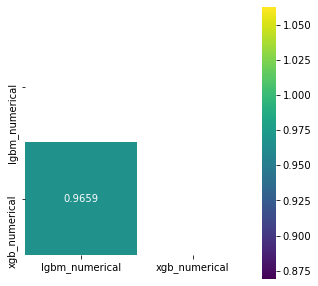

In [13]:
scores_train = pd.DataFrame({
    "lgbm_numerical": lgbm_oof,
    "xgb_numerical": xgb_oof,
     })

corr = scores_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

<AxesSubplot:>

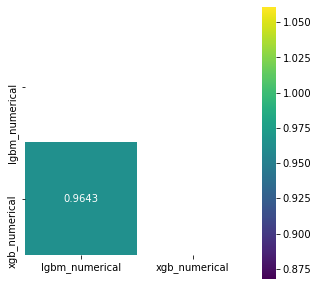

In [14]:
lgbm_pred_valid = lgbm_estimators[0].predict_proba(X_valid)[:, 1]
xgb_pred_valid = xgb_estimators[0].predict_proba(X_valid)[:, 1]

stats.loc['LightGBM', 'score_valid'] = roc_auc_score(y_valid, lgbm_pred_valid)
stats.loc['XGBoost', 'score_valid'] = roc_auc_score(y_valid, xgb_pred_valid)

scores_valid = pd.DataFrame({
    "lgbm_numerical": lgbm_pred_valid,
    "xgb_numerical": xgb_pred_valid,
     })

corr = scores_valid.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

## Усреднение прогнозов

**Задание 2.** Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

In [15]:
scores_mean = scores_valid.mean(axis=1)
score = roc_auc_score(y_valid, scores_mean)
print(f"Score = {round(score, 4)}")

stats.loc['AMean2', 'score_valid'] = score

Score = 0.7122


In [16]:
scores_mean = gmean(scores_valid, axis=1)
score = roc_auc_score(y_valid, scores_mean)
print(f"Score = {round(score, 4)}")

stats.loc['GMean2', 'score_valid'] = score

Score = 0.7122


In [17]:
# ROC-AUC / GINI
scores_mean = scores_valid.rank().mean(axis=1)
score = roc_auc_score(y_valid, scores_mean)
print(f"Score = {round(score, 4)}")

stats.loc['Rankdata_GINI2', 'score_valid'] = score

Score = 0.7117


In [18]:
scores_mean = gmean(scores_valid.rank(), axis=1)
score = roc_auc_score(y_valid, scores_mean)
print(f"Score = {round(score, 4)}")

stats.loc['Rankdata2', 'score_valid'] = score

Score = 0.7116


## CatBoost, OOF прогнозы

**Задание 3.** Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

**Обучаем CatBoost**

In [ ]:
cb_params = {"n_estimators": 750,
            "max_depth": 10,
            "learning_rate": 0.005,
            "loss_function": "Logloss",
            "eval_metric": "AUC",
            "verbose": 50,
            "random_state": 42
}

In [19]:
cb_cv = KFold(n_splits=7, random_state=42, shuffle=True)
cb_estimators, _, cb_oof = catboost_cross_validation(cb_params, X_train, y_train, cb_cv)

Sun Apr 11 18:05:16 2021, Cross-Validation, 77065 rows, 57 cols
0:	test: 0.5733246	test1: 0.5548941	best: 0.5548941 (0)	total: 123ms	remaining: 1m 32s
50:	test: 0.7476349	test1: 0.6824312	best: 0.6828050 (46)	total: 2.98s	remaining: 40.8s
100:	test: 0.7543291	test1: 0.6917247	best: 0.6919605 (99)	total: 5.9s	remaining: 37.9s
150:	test: 0.7559470	test1: 0.6927395	best: 0.6932966 (142)	total: 8.88s	remaining: 35.2s
200:	test: 0.7567003	test1: 0.6933967	best: 0.6933967 (200)	total: 11.8s	remaining: 32.2s
250:	test: 0.7586836	test1: 0.6951796	best: 0.6951796 (250)	total: 14.7s	remaining: 29.2s
300:	test: 0.7629922	test1: 0.6969217	best: 0.6969217 (300)	total: 17.6s	remaining: 26.3s
350:	test: 0.7658119	test1: 0.6994130	best: 0.6994833 (349)	total: 20.6s	remaining: 23.4s
400:	test: 0.7698007	test1: 0.7020618	best: 0.7020618 (400)	total: 23.6s	remaining: 20.5s
450:	test: 0.7735172	test1: 0.7041121	best: 0.7041261 (449)	total: 26.5s	remaining: 17.6s
500:	test: 0.7772160	test1: 0.7057673	best:

300:	test: 0.7629788	test1: 0.6910052	best: 0.6910056 (293)	total: 18.3s	remaining: 27.3s
350:	test: 0.7666746	test1: 0.6938394	best: 0.6938394 (350)	total: 21.3s	remaining: 24.2s
400:	test: 0.7688547	test1: 0.6961438	best: 0.6961438 (400)	total: 24.2s	remaining: 21.1s
450:	test: 0.7716955	test1: 0.6973906	best: 0.6973906 (450)	total: 27.3s	remaining: 18.1s
500:	test: 0.7762458	test1: 0.6986965	best: 0.6986965 (500)	total: 30.3s	remaining: 15s
550:	test: 0.7806778	test1: 0.6995473	best: 0.6995473 (550)	total: 33.2s	remaining: 12s
600:	test: 0.7859506	test1: 0.7007434	best: 0.7007708 (598)	total: 36.2s	remaining: 8.97s
650:	test: 0.7896128	test1: 0.7011223	best: 0.7013468 (631)	total: 39.1s	remaining: 5.95s
700:	test: 0.7941739	test1: 0.7020903	best: 0.7021170 (699)	total: 42s	remaining: 2.94s
749:	test: 0.7993595	test1: 0.7026019	best: 0.7026167 (740)	total: 44.9s	remaining: 0us

bestTest = 0.702616743
bestIteration = 740

Shrink model to first 741 iterations.
Fold 6, Valid score = 0.7

In [20]:
cb_score = roc_auc_score(y_train, cb_oof)
print(f"Score = {round(cb_score, 4)}")

Score = 0.706


**OOF прогнозы и Корреляция**

<AxesSubplot:>

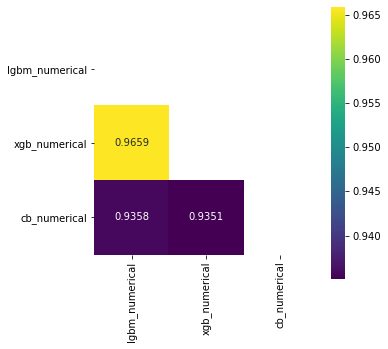

In [21]:
scores_train = pd.DataFrame({
    "lgbm_numerical": lgbm_oof,
    "xgb_numerical": xgb_oof,
    "cb_numerical": cb_oof
     })

corr = scores_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

<AxesSubplot:>

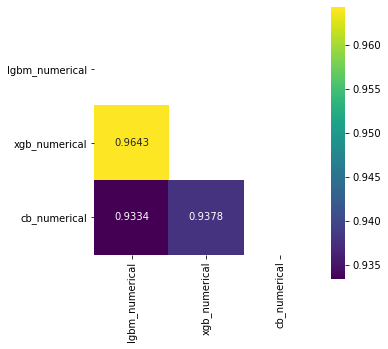

In [22]:
lgbm_pred_valid = lgbm_estimators[0].predict_proba(X_valid)[:, 1]
xgb_pred_valid = xgb_estimators[0].predict_proba(X_valid)[:, 1]
cb_pred_valid = cb_estimators[0].predict_proba(X_valid)[:, 1]

stats.loc['CatBoost', 'score_valid'] = roc_auc_score(y_valid, cb_pred_valid)

scores_valid = pd.DataFrame({
    "lgbm_numerical": lgbm_pred_valid,
    "xgb_numerical": xgb_pred_valid,
    "cb_numerical": cb_pred_valid,
     })

corr = scores_valid.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

## Усреднение прогнозов для 3 моделей

**Задание 4.** Выполнить задание 2 для трех моделей.

In [23]:
scores_mean = scores_valid.mean(axis=1)
score = roc_auc_score(y_valid, scores_mean)
print(f"Score = {round(score, 4)}")

stats.loc['AMean3', 'score_valid'] = score

Score = 0.7134


In [24]:
scores_mean = gmean(scores_valid, axis=1)
score = roc_auc_score(y_valid, scores_mean)
print(f"Score = {round(score, 4)}")

stats.loc['GMean3', 'score_valid'] = score

Score = 0.7135


In [25]:
# ROC-AUC / GINI
scores_mean = scores_valid.rank().mean(axis=1)
score = roc_auc_score(y_valid, scores_mean)
print(f"Score = {round(score, 4)}")

stats.loc['Rankdata_GINI3', 'score_valid'] = score

Score = 0.7131


In [26]:
scores_mean = gmean(scores_valid.rank(), axis=1)
score = roc_auc_score(y_valid, scores_mean)
print(f"Score = {round(score, 4)}")

stats.loc['Rankdata3', 'score_valid'] = score

Score = 0.7131


## Логистическая регрессия

**Задание 5. (опция)** Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

In [27]:
model_lr = LogisticRegression(random_state=1)
model_lr.fit(scores_valid, y_valid)

LogisticRegression(random_state=1)

In [28]:
pred_lr = model_lr.predict_proba(scores_valid)[:, 1]
lr_score = roc_auc_score(y_valid, pred_lr)
print(f"Score = {round(lr_score, 4)}")

stats.loc['LogReg', 'score_valid'] = lr_score

Score = 0.7139


In [29]:
stats

,score_valid
LightGBM,0.712864
XGBoost,0.708131
AMean2,0.712204
GMean2,0.712199
Rankdata_GINI2,0.711685
Rankdata2,0.711603
CatBoost,0.710731
AMean3,0.713441
GMean3,0.713499
Rankdata_GINI3,0.713084


**Вывод:** на предиктах трех моделей достигается лучшее качество.

## RandomForest

**Задание 6. (опция)** Обучить алгоритм RandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

In [30]:
X_train.fillna(0, inplace=True)
X_valid.fillna(0, inplace=True)

In [79]:
rf_param = {'n_estimators': 400, 
            'max_depth': 6, 
            'random_state': 1}

rf_model = RandomForestClassifier(**rf_param)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=400, random_state=1)

Score = 0.7421


<AxesSubplot:>

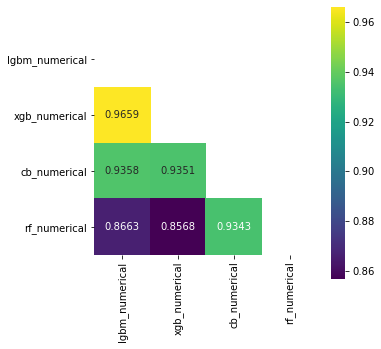

In [80]:
rf_pred_train = rf_model.predict_proba(X_train)[:, 1]
rf_score = roc_auc_score(y_train, rf_pred_train)
print(f"Score = {round(rf_score, 4)}")

scores_train = pd.DataFrame({
    "lgbm_numerical": lgbm_oof,
    "xgb_numerical": xgb_oof,
    "cb_numerical": cb_oof,
    "rf_numerical": rf_pred_train,
     })

corr = scores_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

Score = 0.7019


<AxesSubplot:>

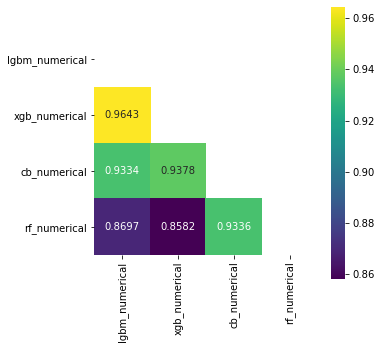

In [81]:
rf_pred_valid = rf_model.predict_proba(X_valid)[:, 1]
rf_score = roc_auc_score(y_valid, rf_pred_valid)
print(f"Score = {round(rf_score, 4)}")

scores_valid = pd.DataFrame({
    "lgbm_numerical": lgbm_pred_valid,
    "xgb_numerical": xgb_pred_valid,
    "cb_numerical": cb_pred_valid,
    "rf_numerical": rf_pred_valid,
     })

stats.loc['RandomForest', 'score_valid'] = rf_score

corr = scores_valid.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [82]:
model_lr2 = LogisticRegression(random_state=1)
model_lr2.fit(scores_valid, y_valid)

LogisticRegression(random_state=1)

In [83]:
pred_lr2 = model_lr2.predict_proba(scores_valid)[:, 1]
lr_score2 = roc_auc_score(y_valid, pred_lr2)
print(f"Score = {round(lr_score2, 4)}")

stats.loc['LogReg2', 'score_valid'] = lr_score2

Score = 0.7134


In [84]:
stats

,score_valid
LightGBM,0.712864
XGBoost,0.708131
AMean2,0.712204
GMean2,0.712199
Rankdata_GINI2,0.711685
Rankdata2,0.711603
CatBoost,0.710731
AMean3,0.713441
GMean3,0.713499
Rankdata_GINI3,0.713084


**Вывод:** RandomForestClassifier ухудшает результат, вероятно на предиктах LightGBM и CatBoost удастся достигнуть лучших результатов.